# SIR Model of Covid-19 spread

The SIR model is one of the simplest compartmental models, and many models are derivatives of this basic form. The model consists of three compartments: S for the number of susceptible, I for the number of infectious, and R for the number of recovered or deceased (or immune) individuals.[1](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)

This is an extended model of the SIR basic model presented by Ben Sparks and John Sandall in the PyData Bristol Masterclass ["Building an interactive coronavirus model in Jupyter"](https://www.crowdcast.io/e/pydata1).
The extension includes:
* Adding the deceased variable (D) as it was assumed to be part of the Recovered (R) variable in the basic model, which would make it a SIRD model.
* Use of the lastest updated data from [NHS UK]() to plot the model and finetune the parameters.

In [50]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Video
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
%matplotlib inline
print("Libraries imported")

Libraries imported


## SIRD Model of disease outbreak

The four variables we'll use:

S = Susceptible (people who are possibly able to get the disease)
<br>I = Infected (people who have got the disease)
<br>R = Recovered (people who are not infected any more, may be recovered)
<br>D = Deceased (people deceased with covid-19 )
<br>Goal: build up some simple naïve assumptions of how diseases spread & follow the mathematical consequences to make a prediction.

### Initial conditions and assumptions:

In [51]:
# Population of size 1, i.e. 100% (N is between 0 and 1)
N = 1

# Assume percentage of Infected people (1% are Infected)
Istart = 0.01

# Assume initial Susceptible peaople
Sstart = N - Istart

# Nobody yet has Recovered
Rstart = 0

# Nobody yes has Deceased
Dstart = 0

print(f"Starting conditions: N = {N}, S = {Sstart}, I = {Istart}, R = {Rstart}, D = {Dstart}")

Starting conditions: N = 1, S = 0.99, I = 0.01, R = 0, D = 0


In [52]:
## For now, fix these "rate" variables

# transm = Transmission/infection rate, how quickly the disease gets transmitted.
transm = 3.2

# recov = Recovery rate, how quickly people recover, this should be
# smaller as it takes people longer to recover from a disease.
recov = 0.23

# dec = Deceased rate. 
# Initial value is small as it r=takes a while since the beginning of the outbreak to start increasing.
dec = 0.001

# maxT = How long we're going to let the model run for.
maxT = 1

The four equations that form the SIR Model are described (using mathematical notation) as follows:

$\frac{dS}{dT} = - TransmissionRate * S * I$

$\frac{dI}{dT} = TransmissionRate * S * I - RecoveryRate * I - DeceaseRate * I$ 

$\frac{dR}{dt} = RecoveryRate * I$

$\frac{dD}{dt} = DeceasedRate * I$

$\frac

The rate of change of Susceptibles, $\frac{dS}{dT}$, is negative because the rate will go down as more Susceptible people get Infected.
<br>The rate of change of Infected, $\frac{dI}{dT}$, is the number who will become Infected next (those who are Susceptible) less those who Recover or Deceased(the more people become Infected, the more people can Recover or can die).
<br>The rate of change of Recovery, $\frac{dR}{dt}$, is decided by how many people are Infected. 
<br>Same applies for the rate of change of Deceased, $\frac{dD}{dt}$.
<br>Assumption: Infection can only happen once to a person.

In [53]:
def dS_dT(S, I, transm):
    """The rate of change of Susceptibles over time.
    
    Args:
        S (float): Total who are Susceptible.
        I (float): Total who are Infected.
        transm (float): transmission rate.
    
    Returns:
        float: rate of change of Suscpetibles.
    
    Examples:
        
        >> dS_dT(S=0.99, I=0.01, transm=3.2)
        -0.03168
    """
    # Negative because rate will go down as more Susceptible people get Infected.
    return -transm * S * I

def dI_dT(S, I, transm, recov, dec):
    """The rate of change of Infected people over time.
    
    Args:
        S (float): Total who are Susceptible.
        I (float): Total who are Infected.
        transm (float): transmission rate.
        recov (float): recovery rate.
        dec (float): deceased rate.
    
    Returns:
        float: rate of change of Infected.
    
    Examples:
    
        >> dI_dT(S=0.99, I=0.01, transm=3.2, recov=0.23, dec=0.01)
        0.02928
    """
    return (
        transm * S * I  # If people were Susceptible, they'll become Infected next.
        - recov * I  # The more people become Infected, the more people can Recover.
        - dec*I # The more people become Infected, the more people may die.
    )


def dR_dT(I, recov):
    """The rate of change of Recovered people over time.
    
    Args:
        I (float): Total who are Infected.
        recov (float): recovery rate.
    
    Returns:
        float: rate of change of Recovered.
    
    Examples:
    
        >> dR_dT(I=0.01, recov=0.23)
        0.0023
    """
    return recov * I  # Anyone who's Infected can Recover.

def dD_dT(I, dec):
    """The rate of change of Deceased people over time.
    
    Args:
        I (float): Total who are Infected.
        dec (float): decease rate.
    
    Returns:
        float: rate of change of Deceased.
    
    Examples:
    
        >> dD_dT(I=0.01, dec = 0.01)
        0.0001
    """
    return dec * I  # Anyone who's Infected may die.


Solve the system of differential equations!
First we create a single function to hold all four rate equations, because Python's solver function wants to be given a single input function, not four.

In [54]:
def SIRD(t, y):
    """
    This function specifies a system of differential equations to be solved,
    and their parameters. We will pass this to the solve_ivp [1]_ function
    from the scipy library.
    
    Args:
        t (float): time step.
        y (list):  parameters, in this case a list containing [S, I, R, D, transm, recov, dec].
        
    Returns:
        list: Calculated values [S, I, R, D, transm, recov, dec]
    
    Examples:
        
        >>> SIR(t=0, y=[0.99, 0.01, 0.0, 0.0, 3.2, 0.23, 0.01])
        [-0.03168, 0.02938, 0.0023]
    
    .. [1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
    """
    S, I, R, D = y
    return [
        dS_dT(S, I, transm),
        dI_dT(S, I, transm, recov, dec),
        dR_dT(I, recov),
        dD_dT(I, dec),
    ]


# Let's take it for a spin
SIRD(t=0, y=[0.99, 0.01, 0.0, 0.0])

[-0.03168, 0.02937, 0.0023, 1e-05]

In [55]:
# Solve the system of differential equations!
solution = solve_ivp(
    fun=SIRD,  # input function
    t_span=[0, maxT],  # start at time 0 and continue until we get to maxT
    t_eval=np.arange(0, maxT, 0.1),  # points at which to store the computed solutions
    y0=[Sstart, Istart, Rstart, Dstart],  # initial conditions
)
solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 26
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
 t_events: None
        y: array([[9.90000000e-01, 9.86325240e-01, 9.81424941e-01, 9.74907905e-01,
        9.66271444e-01, 9.54911223e-01, 9.40077904e-01, 9.20785558e-01,
        8.96042778e-01, 8.64875901e-01],
       [1.00000000e-02, 1.34062917e-02, 1.79469647e-02, 2.39831809e-02,
        3.19773924e-02, 4.24830279e-02, 5.61842191e-02, 7.39816927e-02,
        9.67620641e-02, 1.25374724e-01],
       [0.00000000e+00, 2.67306154e-04, 6.25374981e-04, 1.10411393e-03,
        1.74358285e-03, 2.59446925e-03, 3.72169536e-03, 5.21009629e-03,
        7.16400966e-03, 9.70717007e-03],
       [0.00000000e+00, 1.16220067e-06, 2.71902166e-06, 4.80049536e-06,
        7.58079500e-06, 1.12803011e-05, 1.61812842e-05, 2.26525926e-05,
        3.11478681e-05, 4.22050873e-05

Let's create a pandas DataFrame with the calculated SIRD values (solution.y) in the cells and the time steps (solution.t) as the index.

In [56]:
df = pd.DataFrame(
    solution.y.T, columns=["Susceptible", "Infected", "Recovered", "Deceased"], index=solution.t,
)
df

,Susceptible,Infected,Recovered,Deceased
0.0,0.990000,0.010000,0.000000,0.000000
0.1,0.986325,0.013406,0.000267,0.000001
0.2,0.981425,0.017947,0.000625,0.000003
0.3,0.974908,0.023983,0.001104,0.000005
0.4,0.966271,0.031977,0.001744,0.000008
0.5,0.954911,0.042483,0.002594,0.000011
0.6,0.940078,0.056184,0.003722,0.000016
0.7,0.920786,0.073982,0.005210,0.000023
0.8,0.896043,0.096762,0.007164,0.000031
0.9,0.864876,0.125375,0.009707,0.000042


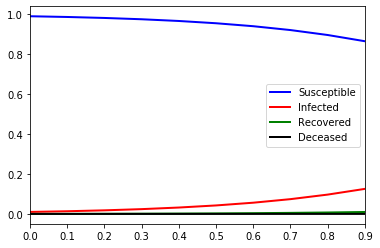

In [57]:
# Visualise the result!
plot = df.plot(color=["blue", "red", "green", "black"], lw=2)

## Visualisation
Let make a helper function which also adds a larger x-axis.

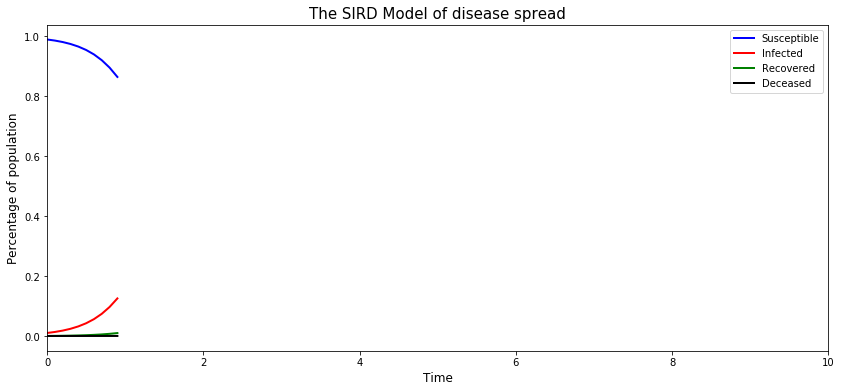

In [58]:
def plot_curves(solution, xlim=[0, 10], title=None, add_background=False):
    """Helper function that takes a solution and optionally visualises it
       using official Numberphile brown paper.
    
    Args:
        solution (scipy.integrate._ivp.ivp.OdeResult): Output of solve_ivp() function.
        xlim (list): x-axis limits in format [min, max].
        title (str): Optional graph title.
        add_background (bool): Add Numberphile brown paper background?
    
    Returns:
        matplotlib graph of SIR model curves.
    
    Examples:
    
        >>> solution = solve_ivp(SIR, t_span=[0, maxT], t_eval=np.arange(0, maxT, 0.1),
                                 y0=[Sstart, Istart, Rstart])
        >>> plot_curves(solution, title="The SIR Model of disease spread")
    """
    # Set up plot
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.title(title, fontsize=15)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Percentage of population", fontsize=12)
    # Create DataFrame
    df = pd.DataFrame(
        solution.y.T,
        columns=["Susceptible", "Infected", "Recovered", "Deceased"],
        index=solution.t,
    )
    # Make the plot
    plot = df.plot(color=["blue", "red", "green", "black"], lw=2, ax=ax)
    plot.set_xlim(xlim[0], xlim[1])


plot_curves(solution, title="The SIRD Model of disease spread")

Let's also create another helper function that plugs into the ipywidgets interact, so we can play around with the parameters.

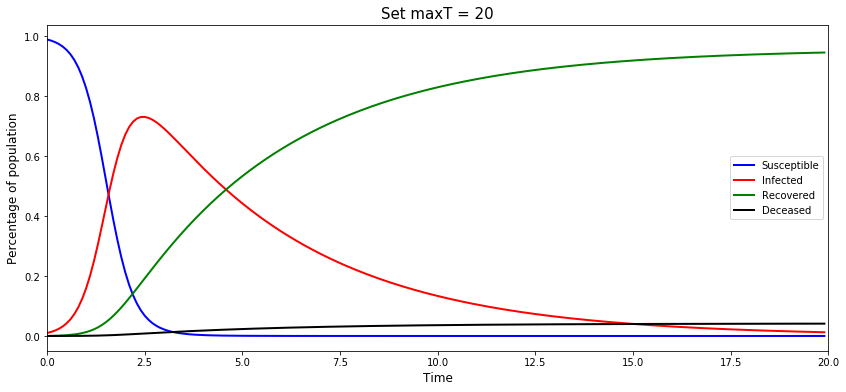

In [59]:
def solve_and_plot(
    Istart=0.01,
    Rstart=0,
    Dstart=0,
    transm=3.2,
    recov=0.23,
    dec=0.01,
    maxT=20,
    title=None,
    add_background=False,
):
    """Helper function so we can play around with the parameters using the interact ipywidget.
    
    Args:
        Istart (float): Starting value for Infected (as percent of population).
        Rstart (float): Starting value for Recovered (as percent of population).
        Dstart (float): Starting values for Deceased (as percentage of population).
        transm (float): transmission rate.
        recov  (float): recovery rate.
        dec    (float): decease rate.
        maxT (int): maximum time step.
        title (str): Optional graph title.
        add_background (bool): Optionally add Numberphile background.
    
    Returns:
        matplotlib graph of SIRD model curves.
    
    Examples:
    
        >>> solve_and_plot(maxT=20, title="Set maxT = 20")
    """

    N = 1
    Sstart = N - Istart

    def SIRD(t, y):
        """We need to redefine this inside solve_and_plot() otherwise it
           won't pick up any changes to transm or recov.
        """
        S, I, R, D = y
        return [
            dS_dT(S, I, transm),
            dI_dT(S, I, transm, recov, dec),
            dR_dT(I, recov),
            dD_dT(I, dec),
        ]

    solution = solve_ivp(
        fun=SIRD,
        t_span=[0, maxT],
        t_eval=np.arange(0, maxT, 0.1),
        y0=[Sstart, Istart, Rstart, Dstart],
    )
    plot_curves(solution, xlim=[0, maxT], title=title, add_background=add_background)


# Let's set maxT to 20 to see how things pan out
solve_and_plot(maxT=20, title="Set maxT = 20")

## Adding interactivity
We can make this interactive using the interact function from ipywidgets!
<br> Try flattening the curve by reducing the transmition rate `transm`
Note: we use interact_manual in order to add a button as the graph can take a couple seconds to update.

In [60]:
interact_manual(
    solve_and_plot,
    Istart=(0, 1, 0.01),
    Rstart=(0, 1, 0.01),
    Dstart= (0, 1, 0.01),
    transm=(0, 10, 0.01),
    recov=(0, 1, 0.01),
    dec=(0, 1, 0.01),
    maxT=(0, 50, 1),
    title="",
)

interactive(children=(FloatSlider(value=0.01, description='Istart', max=1.0, step=0.01), FloatSlider(value=0.0…

<function __main__.solve_and_plot(Istart=0.01, Rstart=0, Dstart=0, transm=3.2, recov=0.23, dec=0.01, maxT=20, title=None, add_background=False)>

If you reduce the transmission rate enough, it turns out that not everyone ends up being infected. There's still 10% - 20% of people who remain susceptible in the long run but they never get the disease.

This is what we're hoping for with COVID-19, as there are some people who will not survive the disease. If you can stop the 10% most vulnerable from getting it, this would be great.

## Lights, camera, animate!
Let's create an animated chart in Python for maximum social media virality.

In [61]:
# First, let's run the numbers
transm = 2.4
recov = 0.3
dec = 0.01
maxT = 13


def SIRD(t, y):
    S, I, R, D = y
    return [
        dS_dT(S, I, transm),
        dI_dT(S, I, transm, recov, dec),
        dR_dT(I, recov),
        dD_dT(I, dec),
    ]


solution = solve_ivp(
    fun=SIRD,
    t_span=[0, maxT],
    t_eval=np.arange(0, maxT, 0.1),
    y0=[Sstart, Istart, Rstart, Dstart],
)
df = pd.DataFrame(
    solution.y.T, columns=["Susceptible", "Infected", "Recovered", "Deceased"], index=solution.t,
)
df.head()

,Susceptible,Infected,Recovered,Deceased
0.0,0.990000,0.010000,0.000000,0.000000
0.1,0.987365,0.012291,0.000333,0.000011
0.2,0.984136,0.015096,0.000743,0.000025
0.3,0.980188,0.018525,0.001245,0.000042
0.4,0.975366,0.022711,0.001861,0.000062


We need to enable matplotlib's "notebook" plotting mode in order to see the graphs animating live in the notebook.

In [62]:
%matplotlib notebook
%matplotlib notebook
# See here for why we call this twice: https://github.com/ipython/ipython/issues/10873

<IPython.core.display.Javascript object>


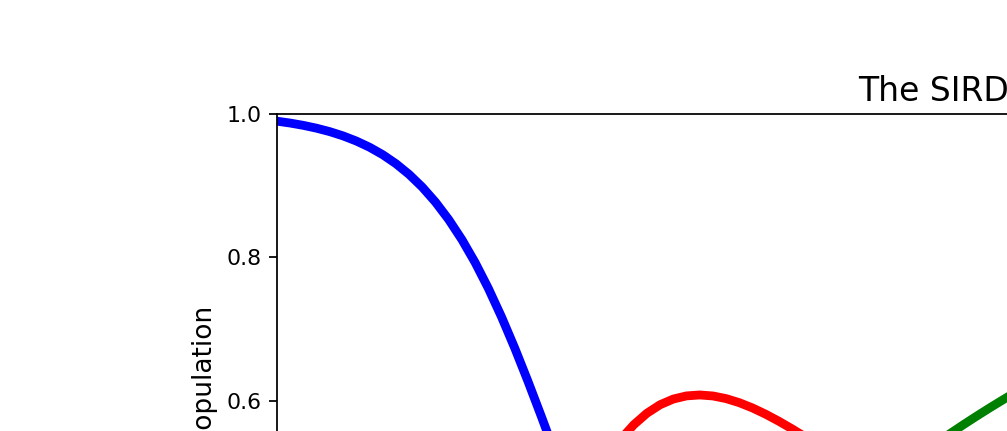

In [69]:
def animate(i):
    """We put all the animation update code into one function
       that loads the first i rows from the dataframe df."""
    ax.clear()
    data = df.iloc[: i + 1]
    plot = data.plot(color=["blue", "red", "green", "black"], lw=4, ax=ax)
    plt.title("The SIRD curve of spread disease", fontsize=15)
    plt.xlabel("Time (units)", fontsize=12)
    plt.ylabel("Percentage of population", fontsize=12)
    plot.set_xlim(0, maxT)
    plot.set_ylim(0, 1)


fig, ax = plt.subplots(figsize=(14, 6))
animate(0)  # initialise the plot
ani = FuncAnimation(
    fig, animate, frames=list(range(len(df))), repeat=False, interval=50, blit=True,
)
plt.show()

In [73]:
ani.save("images/coronavirus_curve_no_background.mp4")

/git/github.com/mtreinish/ciml/.venv-mpl/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
